# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [2]:
filename_features = "Dados/features.txt"
filename_labels = "Dados/activity_labels.txt"

filename_subtrain = "Dados/train/subject_train.txt"
filename_xtrain = "Dados/train/X_train.txt"
filename_ytrain = "Dados/train/y_train.txt"

filename_subtest = "Dados/test/subject_test.txt"
ffilename_xtest = "Dados/test/X_test.txt"
filename_ytest = "Dados/test/y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], squeeze=True, sep="#")
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'], squeeze=True)
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'], squeeze=True)
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

C:\Users\ricme\AppData\Local\Temp\ipykernel_18528\1720571078.py:12: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  features = pd.read_csv(filename_features, header=None, names=['nome_var'], squeeze=True, sep="#")
C:\Users\ricme\AppData\Local\Temp\ipykernel_18528\1720571078.py:15: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'], squeeze=True)
C:\Users\ricme\AppData\Local\Temp\ipykernel_18528\1720571078.py:19: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'], squeeze=True)


## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

In [3]:


# Função para calcular a análise PCA e as métricas relacionadas
def perform_pca_and_analyze(data):
    # Realizando PCA
    pca = PCA()
    pca.fit(data)

    # Variância explicada por cada componente
    explained_variance = pca.explained_variance_

    # Variância explicada acumulada
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

    # Variância percentual por componente
    variance_ratio = pca.explained_variance_ratio_

    # Variância percentual acumulada
    cumulative_variance_ratio = np.cumsum(variance_ratio)

    # Determinando o número de componentes para explicar pelo menos 90% da variância
    components_for_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1

    return explained_variance, cumulative_explained_variance, variance_ratio, cumulative_variance_ratio, components_for_90

# Análise PCA para X_train
explained_variance_train, cumulative_explained_variance_train, variance_ratio_train, cumulative_variance_ratio_train, components_for_90_train = perform_pca_and_analyze(X_train)

In [4]:
print(f"Componentes para explicar 90% da variância: {components_for_90_train}")

Componentes para explicar 90% da variância: 34


In [5]:
pd.DataFrame({
    'explained_variance': explained_variance_train,
    'cumulative_explained_variance': cumulative_explained_variance_train,
    'variance_ratio': variance_ratio_train * 100,
    'cumulative_variance_ratio': cumulative_variance_ratio_train *100
}, index=range(1, len(explained_variance_train) + 1))

,explained_variance,cumulative_explained_variance,variance_ratio,cumulative_variance_ratio
1,3.482363e+01,0.625544,6.255444e+01,62.554440
2,2.735046e+00,0.674675,4.913023e+00,67.467463
3,2.294393e+00,0.715889,4.121467e+00,71.588930
4,1.043775e+00,0.734639,1.874956e+00,73.463886
5,9.435170e-01,0.751587,1.694860e+00,75.158746
...,...,...,...,...
557,4.397900e-32,1.000000,7.900043e-32,100.000000
558,5.261320e-33,1.000000,9.451023e-33,100.000000
559,6.745334e-34,1.000000,1.211679e-33,100.000000
560,5.193619e-34,1.000000,9.329410e-34,100.000000


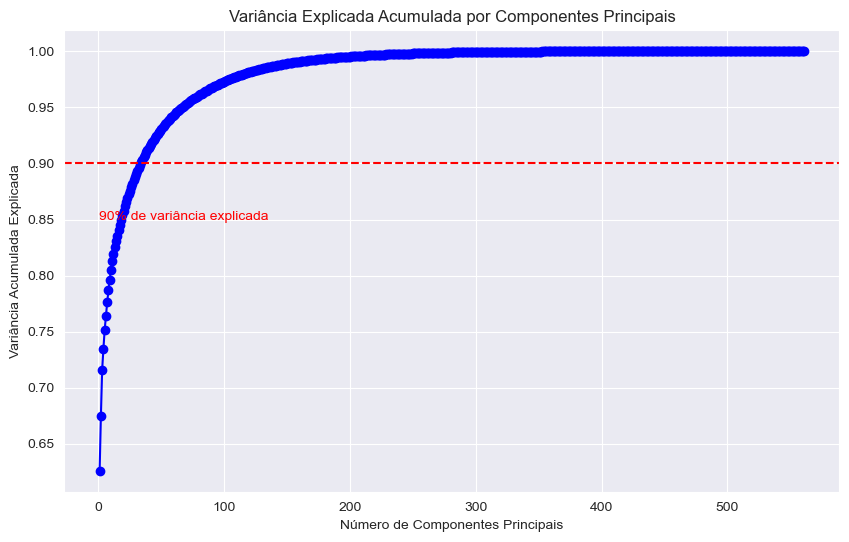

In [6]:
# Total de componentes
num_components = len(variance_ratio_train)
cumulative_variance_explained = np.cumsum(variance_ratio_train)

# Criando o gráfico de linhas para a variância explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_components + 1), cumulative_variance_explained, marker='o', linestyle='-', color='b')

# Adicionando a linha horizontal em 90%
plt.axhline(y=0.9, color='r', linestyle='--')
plt.text(0.5, 0.85, '90% de variância explicada', color = 'red')

plt.title('Variância Explicada Acumulada por Componentes Principais')
plt.ylabel('Variância Acumulada Explicada')
plt.xlabel('Número de Componentes Principais')
plt.show()


In [7]:
#### COM PADRONIZAÇÃO ####
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_scaled = scaler.fit_transform(X_train)

explained_variance_scaled, cumulative_explained_variance_scaled, variance_ratio_scaled, cumulative_variance_ratio_scaled, components_for_90_train_scaled = perform_pca_and_analyze(X_train_scaled)

print(f"Componentes para explicar 90% da variância: {components_for_90_train_scaled}")

Componentes para explicar 90% da variância: 63


In [8]:
pd.DataFrame({
    'explained_variance': explained_variance_scaled,
    'cumulative_explained_variance': cumulative_explained_variance_scaled,
    'variance_ratio': variance_ratio_scaled * 100,
    'cumulative_variance_ratio': cumulative_variance_ratio_scaled *100
}, index=range(1, len(explained_variance_scaled) + 1))

,explained_variance,cumulative_explained_variance,variance_ratio,cumulative_variance_ratio
1,2.849211e+02,0.507812,5.078117e+01,50.781172
2,3.692264e+01,0.573619,6.580680e+00,57.361853
3,1.574625e+01,0.601683,2.806437e+00,60.168289
4,1.404909e+01,0.626722,2.503953e+00,62.672242
5,1.059472e+01,0.645605,1.888285e+00,64.560527
...,...,...,...,...
557,1.822955e-30,1.000000,3.249032e-31,100.000000
558,1.822955e-30,1.000000,3.249032e-31,100.000000
559,1.822955e-30,1.000000,3.249032e-31,100.000000
560,1.446735e-31,1.000000,2.578499e-32,100.000000


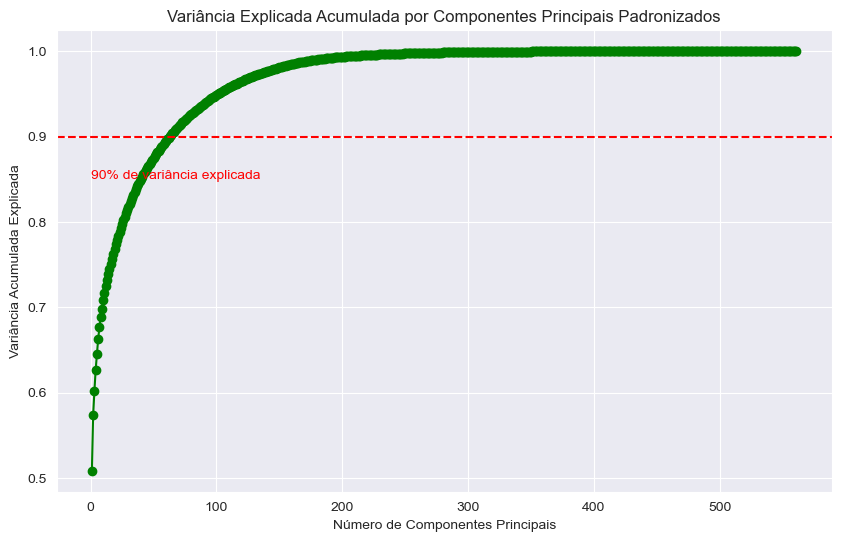

In [9]:
# Total de componentes
num_components = len(variance_ratio_scaled)
cumulative_variance_explained = np.cumsum(variance_ratio_scaled)

# Criando o gráfico de linhas para a variância explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_components + 1), cumulative_variance_explained, marker='o', linestyle='-', color='g')

# Adicionando a linha horizontal em 90%
plt.axhline(y=0.9, color='r', linestyle='--')
plt.text(0.5, 0.85, '90% de variância explicada', color = 'red')

plt.title('Variância Explicada Acumulada por Componentes Principais Padronizados')
plt.ylabel('Variância Acumulada Explicada')
plt.xlabel('Número de Componentes Principais')
plt.show()

## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

In [10]:
%%time
# Padronizar os dados de treino (para uma das árvores)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA com 10 componentes
pca_standardized = PCA(n_components=10)
X_train_pca_standardized = pca_standardized.fit_transform(X_train_scaled)
X_test_pca_standardized = pca_standardized.transform(X_test_scaled)

pca_non_standardized = PCA(n_components=10)
X_train_pca_non_standardized = pca_non_standardized.fit_transform(X_train)
X_test_pca_non_standardized = pca_non_standardized.transform(X_test)

# Criar a Árvore de Decisão com ccp_alpha=0.001
dt_standardized = DecisionTreeClassifier(ccp_alpha=0.001)
dt_non_standardized = DecisionTreeClassifier(ccp_alpha=0.001)

# Treinar as árvores
dt_standardized.fit(X_train_pca_standardized, y_train)
dt_non_standardized.fit(X_train_pca_non_standardized, y_train)

# Avaliar a acurácia
acc_train_std = accuracy_score(y_train, dt_standardized.predict(X_train_pca_standardized))
acc_test_std = accuracy_score(y_test, dt_standardized.predict(X_test_pca_standardized))

acc_train_non_std = accuracy_score(y_train, dt_non_standardized.predict(X_train_pca_non_standardized))
acc_test_non_std = accuracy_score(y_test, dt_non_standardized.predict(X_test_pca_non_standardized))

# Comparar as acurácias
print("Árvore com Dados Padronizados - Acurácia Treino:", acc_train_std, "Acurácia Teste:", acc_test_std)
print("Árvore com Dados Não Padronizados - Acurácia Treino:", acc_train_non_std, "Acurácia Teste:", acc_test_non_std)

Árvore com Dados Padronizados - Acurácia Treino: 0.8624863982589771 Acurácia Teste: 0.7723108245673567
Árvore com Dados Não Padronizados - Acurácia Treino: 0.8932263329706203 Acurácia Teste: 0.822870715982355
CPU times: total: 2.05 s
Wall time: 1.23 s
